# UChicago Project Lab Autumn 2022 - Mizuho 

## 1. Introduction

### 1.1. Short story of derivatives price

A burger is priced at $10. How is the price determined? This may include __material cost__ (raw materials, labour) and __profit__. 
However, also should include for example __waste cost__ (if not purchased), __funding cost__ (interest for loan for business), __operational cost__ (rent, utility), etc. 

In classic theory of derivatives pricing, researchers/practitioners focused on derivatives price based on __material cost__:
For instance, in the well known BS (Black-Scholes) model, option prices are determined based on the cost of how we can replicate the economics of options with simpler products, which corresponds to raw materials of derivatives.

However, in the latest market, costs other than raw materials are considered into prices. Those are xVA family.

$$ \mathrm{Contract\ value} = \mathrm{MtM\ value} + \sum_\mathrm{x} \mathrm{xVA} $$

### 1.2 xVA family

xVA stands for x Valuation Adjustments where x represents various types of adjustments such as 
- C for __CVA__ (Credit Valuation Adjustment)
- D for __DVA__ (Debt Valuation Adjustment)
- F for __FVA__ (Funding Valuation Adjustment)
- K for __KVA__ (Capital Valuation Adjustment)
- Col for __ColVA__ (Collateral Valuations Adjustment)
- M for __MVA__ (Margin Valuation Adjustments)

CVA, FVA, and KVA would be major family members attributing to prices in most cases.

## 2. Setting Up

### 2.1. Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from random import choices 
from collections import Counter 
import scipy.stats

### 2.2 Settings and parameters

Column names, file/sheet names, and fixed constant parameters are defined here.

In [2]:
# keys for simulations
trg_pair = 'USD/JPY'

# keys for market data
key_disc = 'DF'
key_term = 'Term'
key_rate = 'Rates'
key_spot = 'FX_Rate'

# file name
file_mkt = 'marketdata_20220802.xlsx'
file_transition_matrix = 'transitionmatrix.xlsx'

# sheet names
sht_dom = 'rates_dom'
sht_fgn = 'rates_fgn'
sht_bss = 'rates_bss'
sht_fxv = 'fx_vols'
sht_fxs = 'fx_spot'
sht_cds = 'cds'

# keys for stats
key_epe = 'EPE'
key_ene = 'ENE'
key_ee  = 'Mean'
lst_exp = [key_epe,key_ene,key_ee]

# fixed parameter
rr_cds = 0.40
rr_cva = 0.40

# parameters for visualization
FIG_SZLG = (12,4.5)
FIG_SZMD = (10,4.0)
FIG_SZSM = (6,4.5)
FONT_TTL = 13.0
LINE_COL = ['mediumblue','crimson','forestgreen']

### 2.3. Data extraction

All market data used in this notebook is stored in the file "marketdata_yyyymmdd.xlsx" and "transitionmatrix.xlsx", which is assumed to be placed at the same directory of this notebook.

- '__rates_dom__' sheet: USD RFR (risk free rate) discount factor series we see (boostrapped on our side).
- '__rates_fgn__' sheet: Foreign RFR discount factor series (JPY here) we see.
- '__rates_bss__' sheet: Cross-currency basis discount factor series we see, which is adjustment to convert foreign DF to USD RFR measure.
- '__fx_vols__' sheet: Forex rate vol in pips (which is 1/10000 for most currencies, but 1/100 for JPY)
- '__fx_spot__' sheet: Forex spot rate we see.
- '__cds__' sheet: CDS proxy curves regressed with our internal statistical model.

In the process below, discount factor for foreign curency will be adjusted to USD measure with basis discount factor being applied.

In [3]:
# discount factors 
df_zcb_usd = pd.read_excel(file_mkt,sheet_name=sht_dom,index_col=0,parse_dates=True) # USD risk free rate discount factor 
df_zcb_fgn = pd.read_excel(file_mkt,sheet_name=sht_fgn,index_col=0,parse_dates=True) # foreign risk free rate discount factor (in this case, JPY)
df_zcb_bss = pd.read_excel(file_mkt,sheet_name=sht_bss,index_col=0,parse_dates=True) # cross-currency risk free discount rate (JPY discount factor to USD risk free rate)

# extract fx implied vols atm
sr_fx_spot = pd.read_excel(file_mkt,sheet_name=sht_fxs,index_col=4,parse_dates=True)[key_spot] # current fx spot rates
sr_fx_vols = pd.read_excel(file_mkt,sheet_name=sht_fxv,index_col=0,parse_dates=True)[trg_pair] # current fx volatilities for USD/JPY
sr_fx_vols = sr_fx_vols/100 # 0.01 for JPY, 0.00001 for others

# quanto adjustment with basis df
df_zcb_fgn[key_disc] = df_zcb_fgn[key_disc] * df_zcb_bss[key_disc]

# extract cds data
df_cds = pd.read_excel(file_mkt,sheet_name=sht_cds,index_col=[0,1,2],parse_dates=True)

# extract transition matrix
transition_mat = pd.read_excel(file_transition_matrix,index_col=0).drop(columns=['SP','NR','Total'])
validation_mat = pd.read_excel(file_transition_matrix,sheet_name=1,index_col=0)

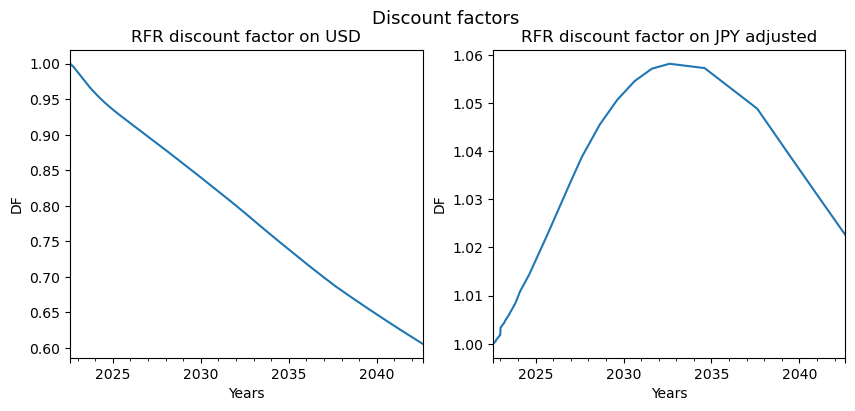

In [4]:
# figure setting
f,ax = plt.subplots(1,2,figsize=FIG_SZMD)
# DF USD
df_zcb_usd[key_disc].plot(ax=ax[0])
ax[0].set_title('RFR discount factor on USD')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('DF')
# DF JPY
df_zcb_fgn[key_disc].plot(ax=ax[1])
ax[1].set_title('RFR discount factor on JPY adjusted')
ax[1].set_xlabel('Years')
ax[1].set_ylabel('DF')
# super title
f.suptitle('Discount factors',fontsize=FONT_TTL)
plt.show()

In [5]:
df_cds

0.5         1.0          2.0          3.0   \
SECTOR     REGION RATING                                                     
Energy     N.Amer AAA       6.941551    8.179805    11.872548    15.287264   
                  AA       12.892075   15.781890    23.894521    31.843166   
                  A        16.665050   20.688468    31.484776    43.354779   
                  BBB      27.445497   33.943340    51.823471    71.171142   
                  BB       96.067291  120.944968   175.250140   226.128970   
                  B       206.662435  241.593897   326.633606   384.935995   
                  CCC     930.362061  942.352620  1058.511276  1145.503223   
Financials N.Amer AAA       7.270894    8.337316    11.803304    15.200447   
                  AA       13.503742   16.085788    23.755163    31.662328   
                  A        17.455726   21.086847    31.301150    43.108567   
                  BBB      28.747653   34.596955    51.521226    70.766960   
                  BB      100.625218  123.273894   174.228044   224.844782   
                  B       216.467566  246.246049   324.728609   382.749940   
                  CCC     974.503231  960.498642  1052.337813  1138.997902   

                                 4.0          5.0          7.0          10.0  \
SECTOR     REGION RATING                                                       
Energy     N.Amer AAA       19.603467    23.968648    31.440009    37.533588   
                  AA        39.913634    48.492258    61.924560    72.634872   
                  A         55.296128    67.784863    85.776683    99.761440   
                  BBB       89.800842   109.586275   137.524367   156.039907   
                  BB       267.728930   308.229032   359.967058   384.433996   
                  B        424.232673   464.802194   512.940125   538.539357   
                  CCC     1209.287845  1256.155365  1257.620133  1210.117844   
Financials N.Amer AAA       19.397754    23.690015    30.229190    35.731443   
                  AA        39.494792    47.928541    59.539718    69.147367   
                  A         54.715866    66.996871    82.473247    94.971475   
                  BBB       88.858497   108.312347   132.228022   148.547778   
                  BB       264.919459   304.645904   346.103988   365.975710   
                  B        419.780897   459.398921   493.185747   512.681827   
                  CCC     1196.597924  1241.552700  1209.186600  1152.015019   

                                15.0        20.0        30.0  
SECTOR     REGION RATING                                      
Energy     N.Amer AAA      46.534190   48.425462   51.590550  
                  AA       78.671195   83.548779   86.670012  
                  A       107.614353  111.995025  116.835399  
                  BBB     168.582213  175.119059  181.292636  
                  BB      379.163234  385.724287  393.164466  
                  B       447.566680  435.419945  439.121454  
                  CCC     779.271886  770.511619  773.063076  
Financials N.Amer AAA      44.913804   46.581717   49.421623  
                  AA       75.931754   80.367754   83.026303  
                  A       103.867070  107.730941  111.923502  
                  BBB     162.711945  168.451599  173.670881  
                  BB      365.960239  371.038270  376.635372  
                  B       431.981782  418.841822  420.660275  
                  CCC     752.136547  741.175259  740.562600

## 3. Preprocessing

### 3.1. Instantaneous interest rates

Given the discount factors above, let's convert them back to instantaneous interest rates assuming piece-wise constant term structure. Let's define $\mathrm{DF}(t)$ as a general discount factor at time $t$ seen at $t=0$, then assuming the piece-wise constant interest rate non-stochastic, the discount factor can be rewritten as
$$ \mathrm{DF}(t) = \mathbb{E}\left[\exp\left\{ -\int_0^t r(s)ds \right\}\right] = \exp\left\{ -\sum_{i=0}^{N-1} r_{t_i}(t_{i+1} - t_i)\right\} $$
where $t_0 = 0, t_1, t_2, \cdots, t_N=t$. Hence, we can extract implied $r_{t_i}$ from shorter grid. That is,
$$ r_{t_i} = \frac{1}{t_{i+1}-t_i}\cdot\frac{\mathrm{DF}(t_i)}{\mathrm{DF}(t_{i+1})} $$

In [6]:
# now convert 
# df_zcb_usd[key_term] and df_zcb_fgn[key_term] is equivalent 
# term -> number of years 
sr_ir_usd = pd.Series(index=df_zcb_usd[key_term],name=key_rate) # USD instantaneous interest rate 
sr_ir_fgn = pd.Series(index=df_zcb_usd[key_term],name=key_rate) # JPY instantaneous interest rate 

# build continuous rates annually scaled (for USD)
for i in range(len(sr_ir_usd)-1): 
    t1, t2 = df_zcb_usd[key_term][i], df_zcb_usd[key_term][i+1]
    d1, d2 = df_zcb_usd[key_disc][i], df_zcb_usd[key_disc][i+1]
    sr_ir_usd.iloc[i] = np.log(d1/d2)/(t2-t1)
sr_ir_usd.iloc[-1] = sr_ir_usd.iloc[-2] # with how index is setup, otherwise will be NaN in last spot 

# build continuous rates annually scaled (for JPY)
for i in range(len(sr_ir_usd)-1):
    t1, t2 = df_zcb_fgn[key_term][i], df_zcb_fgn[key_term][i+1]
    d1, d2 = df_zcb_fgn[key_disc][i], df_zcb_fgn[key_disc][i+1]
    sr_ir_fgn.iloc[i] = np.log(d1/(d2))/(t2-t1)
sr_ir_fgn.iloc[-1] = sr_ir_fgn.iloc[-2] # same as above 

# sr_ir_usd and sr_ir_fgn contain instantaneous interest rates with index of years for usd and jpy respectively 

/var/folders/k3/1j9y9scj5_74yzgkjv_gvpyr0000gn/T/ipykernel_29594/1494315046.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sr_ir_usd = pd.Series(index=df_zcb_usd[key_term],name=key_rate) # USD instantaneous interest rate
/var/folders/k3/1j9y9scj5_74yzgkjv_gvpyr0000gn/T/ipykernel_29594/1494315046.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sr_ir_fgn = pd.Series(index=df_zcb_usd[key_term],name=key_rate) # JPY instantaneous interest rate


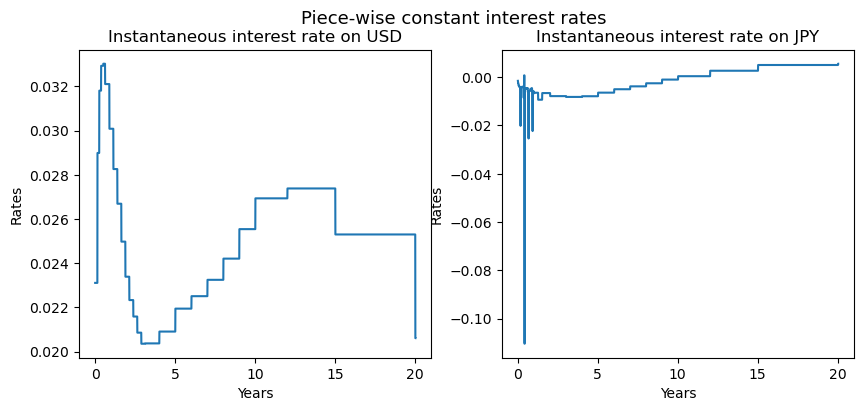

In [7]:
# figure setting
f,ax = plt.subplots(1,2,figsize=FIG_SZMD)
# raes USD
sr_ir_usd.plot(ax=ax[0])
ax[0].set_title('Instantaneous interest rate on USD')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('Rates')
# rates JPY
sr_ir_fgn.plot(ax=ax[1])
ax[1].set_title('Instantaneous interest rate on JPY')
ax[1].set_xlabel('Years')
ax[1].set_ylabel('Rates')
# super title
f.suptitle('Piece-wise constant interest rates',fontsize=FONT_TTL)
plt.show()

### 3.2. Building FX forward volatility

Typically implied volalitities quoted in the market are spot volatilities, which is assumed to be flat over the life of options to expiries. In order to convert them into term structure, bootstrapping is also required.

https://en.wikipedia.org/wiki/Forward_volatility

In [8]:
# build fx forward volatility from implied spot vols 
sr_vols_fwd = sr_fx_vols.copy() # sr_fx_vols are the volatilities of USD/JPY pair 

# bootstrap
for i in range(len(sr_vols_fwd)-1):
    t1, t2 = sr_fx_vols.index[i], sr_fx_vols.index[i+1]
    s1, s2 = sr_fx_vols.values[i], sr_fx_vols.values[i+1]
    # do not overwrite 1st imp vol
    sr_vols_fwd.iloc[i+1] = np.sqrt((s2**2*t2 - s1**2*t1)/(t2-t1))

# build full series (at this point, sr_vols_fwd has only up until 30 -> need to make more continuous)
sr_vols_fwd = pd.concat([sr_vols_fwd,pd.Series(np.nan,index=sr_ir_usd.index)]).sort_index()
sr_vols_fwd = sr_vols_fwd.fillna(method='bfill')

# keep only rates identical daily grids (removes some irrelevant data points)
sr_vols_fwd = sr_vols_fwd.groupby(sr_vols_fwd.index).first()[sr_ir_usd.index]

### 3.3. Renormalizing transition matrix

The D rating can be removed from the transition matrix when simulating rating transitions if desired.

In [9]:
# Eliminates D rating and re-normalizes transition matrix 
# D is naturally removed for ease of calculation for CVA calculation 
remove_d = True # Change to true if want to remove D rating
if remove_d:
    transition_mat = transition_mat.drop(index='D',columns='D')
    for i in transition_mat.index:
        transition_mat.loc[i] = transition_mat.loc[i] / transition_mat.loc[i].sum()

### 3.4. Creating thresholds dataframe

Dataframe to store thresholds for given ratings 

In [10]:
# building rating based threshold table
thresholds = pd.DataFrame(data=float('inf'),index=transition_mat.columns,columns=['CP','US'])
for rating in thresholds.index:
    if rating == 'AA+' or rating == 'AAA':
        thresholds.loc[rating,'CP'] = 200000000
        thresholds.loc[rating,'US'] = 200000000
    elif rating == 'AA-' or rating == 'AA':
        thresholds.loc[rating,'CP'] = 100000000
        thresholds.loc[rating,'US'] = 100000000
    elif rating == 'A+':
        thresholds.loc[rating,'CP'] = 80000000
        thresholds.loc[rating,'US'] = 80000000
    elif rating == 'A-' or rating == 'A':
        thresholds.loc[rating,'CP'] = 60000000
        thresholds.loc[rating,'US'] = 60000000
    elif rating == 'BBB+':
        thresholds.loc[rating,'CP'] = 50000000
        thresholds.loc[rating,'US'] = 50000000
    elif rating == 'BBB':
        thresholds.loc[rating,'CP'] = 50000000
        thresholds.loc[rating,'US'] = 50000000
    elif rating == 'BBB-':
        thresholds.loc[rating,'CP'] = 40000000
        thresholds.loc[rating,'US'] = 40000000
    elif rating == 'BB+':
        thresholds.loc[rating,'CP'] = 30000000
        thresholds.loc[rating,'US'] = 30000000
    elif rating == 'BB':
        thresholds.loc[rating,'CP'] = 20000000
        thresholds.loc[rating,'US'] = 20000000
    elif rating == 'BB-':
        thresholds.loc[rating,'CP'] = 10000000
        thresholds.loc[rating,'US'] = 10000000
    else:
        thresholds.loc[rating,'CP'] = 0
        thresholds.loc[rating,'US'] = 0

thresholds

,CP,US
AAA,200000000.0,200000000.0
AA+,200000000.0,200000000.0
AA,100000000.0,100000000.0
AA-,100000000.0,100000000.0
A+,80000000.0,80000000.0
A,60000000.0,60000000.0
A-,60000000.0,60000000.0
BBB+,50000000.0,50000000.0
BBB,50000000.0,50000000.0
BBB-,40000000.0,40000000.0


## 4. Helper Functions

### 4.1. FX Forward Contract

In [11]:
# class of FX forward
class fxfwd:
    
    def __init__(self, nom_usd=100.0, tenor=1.0, strike=100.0, side=1):
        self.nom_usd = nom_usd
        self.nom_fgn = nom_usd * strike
        self.tenor = tenor
        self.strike = strike
        self.side = side

    def calc_pv(self, df_usd, df_fgn, fx):
        pv = self.side * (df_usd*self.nom_usd - df_fgn*self.nom_fgn/fx)
        return pv

    def calc_fv_series(self, sr_df_usd, sr_df_fgn, sr_fx):
        grid_full = sr_fx.index
        grid_live = grid_full[grid_full<=self.tenor]
        #sim_maturity = [np.maximum(self.tenor - x, 0.0) for x in sim_grid]
        df_usd_mat = sr_df_usd.iloc[sr_df_usd.index.searchsorted(self.tenor)]
        df_fgn_mat = sr_df_fgn.iloc[sr_df_fgn.index.searchsorted(self.tenor)]
        # calculate discount factor as of sim date
        this_df_usd_sim = [df_usd_mat/sr_df_usd.iloc[sr_df_usd.index.searchsorted(x)] for x in grid_live]
        this_df_fgn_sim = [df_fgn_mat/sr_df_fgn.iloc[sr_df_fgn.index.searchsorted(x)] for x in grid_live]
        pvs = [self.calc_pv(df_usd, df_fgn, fx) for df_usd, df_fgn, fx in zip(this_df_usd_sim,this_df_fgn_sim, sr_fx)]
        sr_pvs = pd.Series(np.array(pvs),index=grid_live)
        return sr_pvs

### 4.2. Exposure Profile

Converts dataframe of simulated FV into an expected exposure profile (e.g. EPE, ENE, and mean exposure)

In [12]:
# convert simulated path into exposure profile
def exposure_profile(df_sim):
    sr_epe = np.maximum(df_sim,0.0).mean(axis=1)
    sr_ene = np.minimum(df_sim,0.0).mean(axis=1)
    sr_ee  = sr_epe + sr_ene
    sr_epe.name, sr_ene.name, sr_ee.name = key_epe, key_ene, key_ee
    return pd.concat([sr_epe,sr_ene,sr_ee],axis=1)

### 4.3. Rating Transition Simulation

Simulates a single transition given the current rating and outputs the new rating and threshold

In [14]:
def transition(curr,who,matrix): # Simulate transitions with rating being current transition and who = CP indicating counterparty and who = US indicating us 
    new_rating = choices(matrix.columns,matrix.loc[curr,:])
    new_threshold = thresholds.loc[new_rating,who]

    return new_rating[0], new_threshold[0]

### 4.4. Default Probability Time Series

Generates a time series of PD (probability of default) given CDS ladder quoted.

In [15]:
freq = 7 # reduces total simulations numbers by 7 -> i.e turns x-axis st each point is 7 days 
sim_grid = sr_ir_usd.index[::freq] # reduces total number of simulations 

In [16]:
# generate probability of default data frames
def generate_pd_series(df_cds,sector,region,rr=rr_cds,sim_grid=sim_grid):
    # extract target data
    df_cds_rating = df_cds.loc[(sector,region)]
    df_hzd_spot = df_cds_rating/(1.0-rr)/10000
    df_sp_tenor = np.exp(-df_hzd_spot*df_hzd_spot.columns)

    # boot-restrapped piecewise constant hazard rate
    df_hzd_pw = df_hzd_spot.copy()
    grid_cds = np.concatenate([np.array([0]),df_hzd_pw.columns])
    dt_cds = grid_cds[1:] - grid_cds[:-1]
    # bootstrap after 2nd grid
    for i in range(1,len(dt_cds)):
        df_hzd_pw.iloc[:, i] = (-np.log(df_sp_tenor.iloc[:,i]) - (df_hzd_pw.iloc[:,:i] * dt_cds[:i]).sum(axis=1)) / dt_cds[i]
    
    # building full sp dataframe
    df_hzd_sim = pd.DataFrame(index=sim_grid,columns=df_hzd_pw.index)
    df_hzd_sim = pd.concat([df_hzd_sim,df_hzd_pw.T]).sort_index()
    df_hzd_sim = df_hzd_sim.fillna(method='bfill')
    df_hzd_sim = df_hzd_sim.groupby(df_hzd_sim.index).first().loc[sim_grid]
    
    # building SP series on simulation grid
    hzd_intg = (dts * df_hzd_sim.iloc[1:].T).T.cumsum()
    df_sp_sim = np.exp(-hzd_intg)
    df_sp_sim.loc[0] = 1.0
    df_sp_sim = df_sp_sim.sort_index()
    return df_sp_sim

## 5. Simulations

### 5.1. Monte Carlo simulation with BS model



In [17]:
fx_spot = sr_fx_spot[trg_pair] # FX Spot Rate for just USD/JPY pair (df contains many spot rates)
# simulation parameters 
num_mc = 2000
seed = 1234

We set a less granular simulation time grid (for reduction of computational cost), then generate Monte Carlo paths of FX spot along with time grids. FX spot is assumed to follow Black-Scholes dynamics, log-normally distributed.
$$ \frac{dX_t}{X_t} = (r_t^{d} - r_t^{f})dt + \sigma_t dW_t $$

The dynamics of log of $X_t$ can be derived with Ito formula, with discretization of Eler-Maruyama method as follows:
$$ \Delta(\ln X_t) = \left(r_t^{d} - r_t^{f} - \frac{\sigma^2}{2}\right)\Delta t + \sigma\sqrt{\Delta t}\cdot B_t $$

In [18]:
sr_ir_usd_sim = sr_ir_usd[sim_grid].shift(1) # relevant instantaneous rates of usd, shifts by 1 so t = 0 doesn't have a rate 
sr_ir_fgn_sim = sr_ir_fgn[sim_grid].shift(1) # same thing but with jpy 
sr_vols_fwd_sim = sr_vols_fwd[sim_grid].shift(1) # same thing as last 2 

# time steps 
ts = np.array(sim_grid)
dts = ts[1:] - ts[:-1] # calculates the differences between times 

np.random.seed(seed) # uses selected seed 
rands = np.random.randn(len(dts),num_mc) # generates a series of events for every simulation (i.e for whole time ts x num_mc)

dlnfx = (sr_ir_usd_sim.iloc[1:] - sr_ir_fgn_sim.iloc[1:] - 0.5*sr_vols_fwd_sim.iloc[1:]**2) * dts # calculating discrete time integral
dlnfx = pd.concat([np.array(dlnfx) + np.sqrt(dts)*sr_vols_fwd_sim.iloc[1:]*rands[:,i] for i in range(num_mc)],axis=1) # adding BM component 

# creates num_mc simulations of time ts showing dynamics of ln(X)
dlnfx.loc[0.0] = 0.0 # adds 0 as the dynamics for every sim at time 0 
dlnfx = dlnfx.sort_index() # previous adds to bottom, so now sort to get back in order 

df_fx = fx_spot/np.exp(dlnfx.cumsum(axis=0)) # cumulative sum through time per simulation to calculate simulated fx_rates with following dynamics

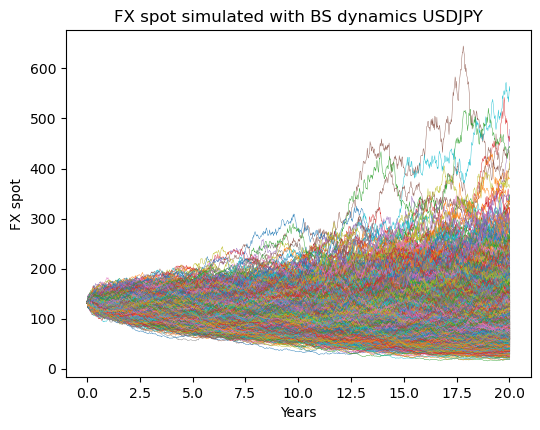

In [19]:
# figure setting
f,ax = plt.subplots(1,1,figsize=FIG_SZSM)
# DF USD
df_fx.plot(ax=ax,linewidth=0.3,legend=None)
ax.set_title('FX spot simulated with BS dynamics USDJPY')
ax.set_xlabel('Years')
ax.set_ylabel('FX spot')
plt.show()

### 5.2. Building and running portfolio simulation

Here we would assume a simple portfolio consisting of just a single FX forward contract currently making around at the market.
- Buying USDJPY (Rec USD vs Pay JPY) at 10y, with notional of USD at $100mm with exchange rate at 99.00 (e.g. paying 9.9bn in JPY)

Note that the PV (or FV, future value) of a FX forward contract at time $t$ can be evaluated as
$$ PV(t) = \pm N^d\left(\mathrm{DF}_t^d(T) - \frac{\bar{X}}{X_t}\mathrm{DF}_t^f(T)\right) $$
where $N_d$ is the nominal in USD, $\bar{X}$ is the exchange rate of the contract. the formula is implemented in the FX forward class and we can apply the simulated FX rate of $X_t$ along with the grids/paths.

In [20]:
cont_nom_usd = 100000000 # notional USD value
cont_tenor = 10 # length of contract -> why it gets reduced 
cont_strike = 99 # exchange rate 
cont_side = 1 

# discount factor series
sr_df_usd = pd.Series(df_zcb_usd[key_disc].values,index=df_zcb_usd[key_term]) # this time, getting discount factor with respect to term (we plotted df with respect to date earlier)
sr_df_fgn = pd.Series(df_zcb_fgn[key_disc].values,index=df_zcb_fgn[key_term]) # same as above, but for foreign JPY discount factor 

cont = fxfwd(cont_nom_usd,cont_tenor,cont_strike,cont_side) # creates fx forward contract object 
df_fvs = pd.concat([cont.calc_fv_series(sr_df_usd,sr_df_fgn,df_fx[x]) for x in df_fx.columns],axis=1) # fair value of contract

### 5.3. Exposure profile

Here let's see how MC simulation worked, and how the exposure profile.

Exposure profile consists of __EPE__ (expected positive exposure), __ENE__ (expected negative exposure), and __EE__/__Mean__ (expected exposure, or mean exposure)).
Whilst we would focus on CVA which requires only EPE through this project, it is worth monitoring whole of exposure profile to deeper understanding of counterparty risk management.
If assuming no MPoR (margin period of risk), exposure profile is defined as

$$ \mathrm{EPE}(t) = \mathbb{E}_t\left\{ \min(\mathrm{FV}^+ (t), T_\mathrm{CP}) \right\}$$
$$ \mathrm{ENE}(t) = \mathbb{E}_t\left\{ \max(\mathrm{FV}^- (t), -T_\mathrm{US}) \right\}$$
$$ \mathrm{EE}(t) = \mathrm{EPE}(t) + \mathrm{ENE}(t)$$
where $T_\mathrm{CP}$ and $T_\mathrm{US}$ are thresholds for counterparty or us defined in a CSA respectively.

For the sample postfolio with a single FX forward contract, you see the EPE and ENE evolve symmetrically both side, then the mean exposure is almost flat. It is reasonable as an FX forward executed ATM has one time CF (cash flow) at the maturity, which should be equally uncertain how much CF would make profit or loss.

>>> plotting simulated results...


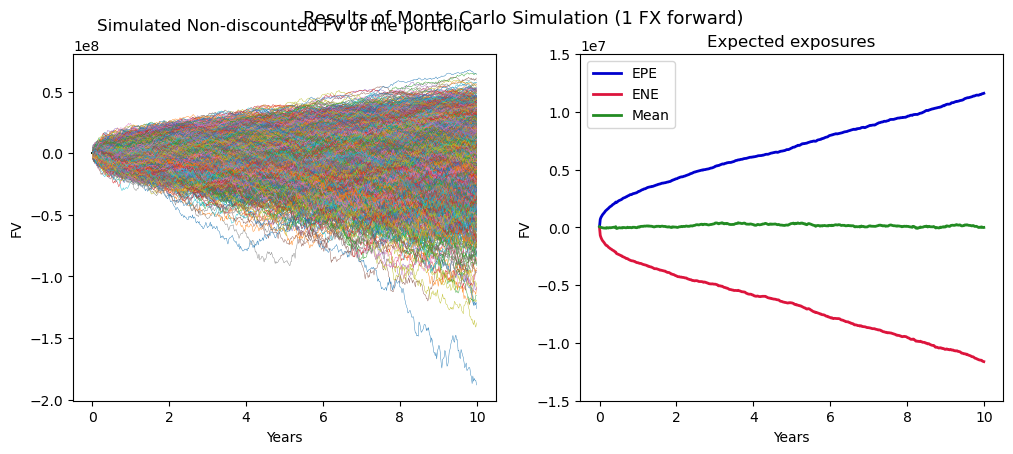

In [21]:
# expected exposures
df_profile = exposure_profile(df_fvs) # generates exposure profile from simulated fair value of contract 

# visualization
print('>>> plotting simulated results...')
f,ax = plt.subplots(1,2,figsize=FIG_SZLG)

# attributions
df_fvs.plot(ax=ax[0],linewidth=0.3,legend=None) # num_mc simulations 
ax[0].set_title('Simulated Non-discounted FV of the portfolio')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('FV')

# expected exposure profile
df_profile.plot(ax=ax[1],linewidth=2.0,linestyle='-',color=LINE_COL) # exposure profile 
ax[1].set_title('Expected exposures')
ax[1].set_xlabel('Years')
ax[1].set_ylabel('FV')
ax[1].set_ylim([-1.5e7,1.5e7])
f.suptitle('Results of Monte Carlo Simulation (1 FX forward)',fontsize=FONT_TTL)
plt.show()

## 6. Impact of CSA

### 6.1. CSA setting

In [23]:
# CSA parameters
mta_cp = 250000 # counterparty minimum transfer amount 
mta_us = 250000 # our minimum transfer amount 

cp_rating = 'BB-'
our_rating = 'A'

eps = .02 

### 6.2. Simulating exposure with static rating

>>> plotting simulated results with CSA...


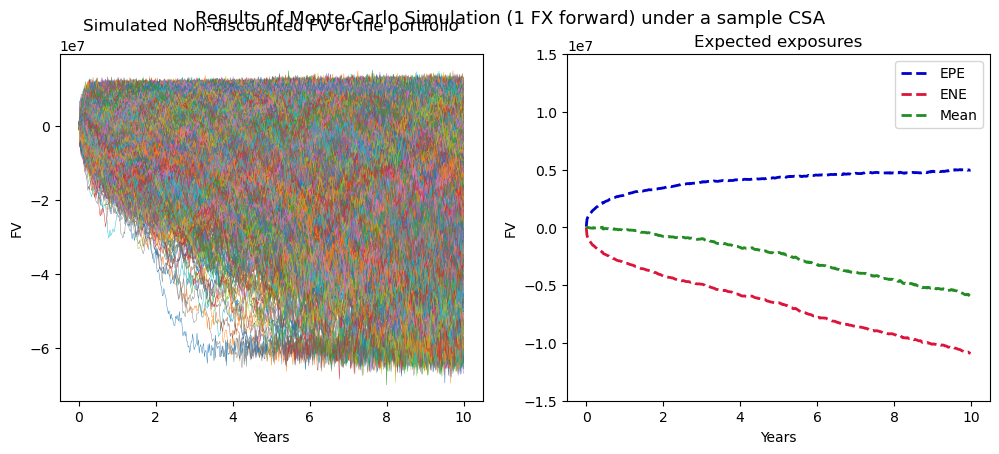

In [26]:
thresh_cp = thresholds.loc[cp_rating,'CP']
thresh_us = thresholds.loc[our_rating,'US']

# collateralized exposure (no MPoR consideration)
df_fvs_csa_static = df_fvs.copy()
collateral_cp = np.maximum(df_fvs - (thresh_cp + mta_cp), 0.0)
collateral_us = np.minimum(df_fvs + (thresh_us + mta_us), 0.0)
# MPoR adjustment example
if True: # True -> MPoR example applies by sim freq
    collateral_cp = collateral_cp.shift(1).fillna(0.0)
    collateral_us = collateral_us.shift(1).fillna(0.0)
# aggregate
df_fvs_csa_static = df_fvs_csa_static - collateral_cp - collateral_us

#df_fvs_csa = np.minimum(df_fvs_csa, thresh_cp + mta_cp)
#df_fvs_csa = np.maximum(df_fvs_csa, (-1.0)*(thresh_us + mta_us))

# expectedf exposures
df_profile_csa_static = exposure_profile(df_fvs_csa_static)
# visualization
print('>>> plotting simulated results with CSA...')
f,ax = plt.subplots(1,2,figsize=FIG_SZLG)
# attributions
df_fvs_csa_static.plot(ax=ax[0],linewidth=0.3,legend=None)
ax[0].set_title('Simulated Non-discounted FV of the portfolio')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('FV')
# expected exposure profile
df_profile_csa_static.plot(ax=ax[1],linewidth=2.0,linestyle='--',color=LINE_COL)
ax[1].set_title('Expected exposures')
ax[1].set_xlabel('Years')
ax[1].set_ylabel('FV')
ax[1].set_ylim([-1.5e7,1.5e7])
f.suptitle('Results of Monte Carlo Simulation (1 FX forward) under a sample CSA',fontsize=FONT_TTL)
plt.show()

### 6.3. Generating sequence of simulated transitions 

In [27]:
thresh_cp = pd.DataFrame(index=df_fvs.index,columns=df_fvs.columns)
rating_cp = pd.DataFrame(index=df_fvs.index,columns=df_fvs.columns)

for n in thresh_cp.columns: # Counterparty
    if n % 100 == 0:
        print('Progress: ', n/len(thresh_cp.columns))
    simt = [] # Threshold 
    simr = [] # Rating 
    current = cp_rating 
    for t in thresh_cp.index:
        if t == 0: # if start of new simulation, add time-0 values 
            simt.append(thresholds.loc[current, 'CP'])
            simr.append(current)
        else:
            if abs(t - np.ceil(t)) < eps: # simulate once a year 
                current, threshold = transition(current, 'CP',transition_mat)
            simt.append(thresholds.loc[current, 'CP'])
            simr.append(current)
    thresh_cp[n] = simt 
    rating_cp[n] = simr 


Progress:  0.0
Progress:  0.05
Progress:  0.1
Progress:  0.15
Progress:  0.2
Progress:  0.25
Progress:  0.3
Progress:  0.35
Progress:  0.4
Progress:  0.45
Progress:  0.5
Progress:  0.55
Progress:  0.6
Progress:  0.65
Progress:  0.7
Progress:  0.75
Progress:  0.8
Progress:  0.85
Progress:  0.9
Progress:  0.95


In [28]:
thresh_us = pd.DataFrame(index=df_fvs.index,columns=df_fvs.columns)
rating_us = pd.DataFrame(index=df_fvs.index,columns=df_fvs.columns)

for n in thresh_us.columns: # Counterparty
    if n % 100 == 0:
        print('Progress: ', n/len(thresh_us.columns))
    simt = [] # Threshold 
    simr = [] # Rating 
    current = our_rating
    for t in thresh_cp.index:
        if t == 0: # if start of new simulation, add time-0 values 
            simt.append(thresholds.loc[current, 'US'])
            simr.append(current)
        else:
            if abs(t - np.ceil(t)) < eps:
                current, threshold = transition(current, 'US',transition_mat)
            simt.append(thresholds.loc[current, 'US'])
            simr.append(current)
    thresh_us[n] = simt 
    rating_us[n] = simr 

Progress:  0.0
Progress:  0.05
Progress:  0.1
Progress:  0.15
Progress:  0.2
Progress:  0.25
Progress:  0.3
Progress:  0.35
Progress:  0.4
Progress:  0.45
Progress:  0.5
Progress:  0.55
Progress:  0.6
Progress:  0.65
Progress:  0.7
Progress:  0.75
Progress:  0.8
Progress:  0.85
Progress:  0.9
Progress:  0.95


### 6.3. Plotting exposure profile with rating transitions

In [29]:
df_fvs_cp_adj = df_fvs - thresh_cp 
df_fvs_cp_adj = df_fvs_cp_adj - mta_cp 

df_fvs_us_adj = df_fvs + thresh_us 
df_fvs_us_adj = df_fvs_us_adj + mta_us 

>>> plotting simulated results with CSA...


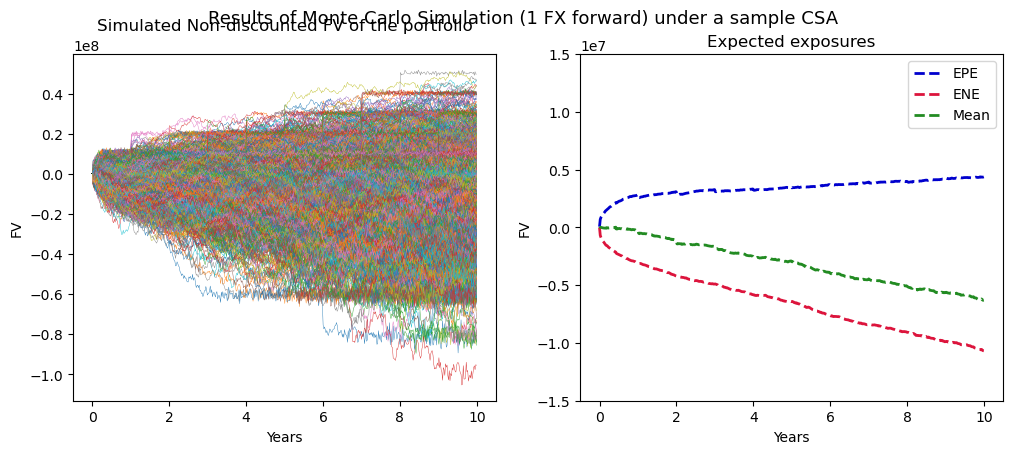

In [30]:
# collateralized exposure (no MPoR consideration)
df_fvs_csa_trans = df_fvs.copy()
collateral_cp = np.maximum(df_fvs_cp_adj, 0.0) # for each element of the dataframe this calculation is done 
collateral_us = np.minimum(df_fvs_us_adj, 0.0)

# MPoR adjustment example
if True: # True -> MPoR example applies by sim freq
    collateral_cp = collateral_cp.shift(1).fillna(0.0)
    collateral_us = collateral_us.shift(1).fillna(0.0)
# aggregate
df_fvs_csa_trans = df_fvs_csa_trans - collateral_cp - collateral_us

# expectedf exposures
df_profile_csa_trans = exposure_profile(df_fvs_csa_trans) # exposure profile of above df 
# visualization
print('>>> plotting simulated results with CSA...')
f,ax = plt.subplots(1,2,figsize=FIG_SZLG)
# attributions
df_fvs_csa_trans.plot(ax=ax[0],linewidth=0.3,legend=None) # the calculations 
ax[0].set_title('Simulated Non-discounted FV of the portfolio')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('FV')
# expected exposure profile
df_profile_csa_trans.plot(ax=ax[1],linewidth=2.0,linestyle='--',color=LINE_COL)
ax[1].set_title('Expected exposures')
ax[1].set_xlabel('Years')
ax[1].set_ylabel('FV')
ax[1].set_ylim([-1.5e7,1.5e7])
f.suptitle('Results of Monte Carlo Simulation (1 FX forward) under a sample CSA',fontsize=FONT_TTL)
plt.show()

### 6.4. Exposure comparison

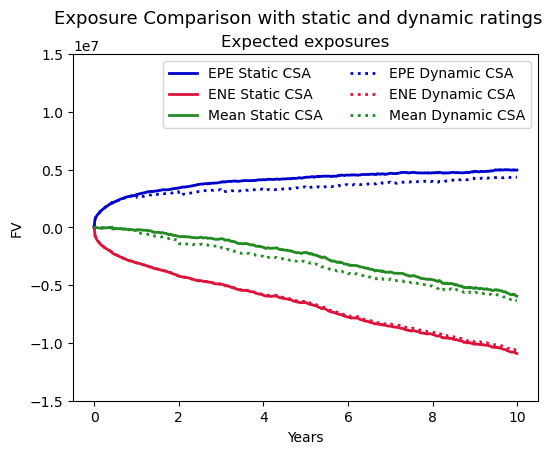

In [31]:
f,ax = plt.subplots(1,1,figsize=FIG_SZSM)
# legend list
lst_legend = [x+' Static CSA' for x in lst_exp] + [x+' Dynamic CSA' for x in lst_exp]
# expected exposure profile
df_profile_csa_static.plot(ax=ax,linewidth=2.0,linestyle='-',color=LINE_COL)
df_profile_csa_trans.plot(ax=ax,linewidth=2.0,linestyle=':',color=LINE_COL)
ax.set_title('Expected exposures')
ax.set_xlabel('Years')
ax.set_ylabel('FV')
ax.set_ylim([-1.5e7,1.5e7])
ax.legend(lst_legend,ncol=2)
f.suptitle('Exposure Comparison with static and dynamic ratings',fontsize=FONT_TTL)
plt.show()

## 7. Estimates of CVA

### 7.1. PD series from CDS 

In [32]:
trg_sector, our_sector = 'Energy', 'Financials'
trg_region, our_region = 'N.Amer', 'N.Amer'
trg_rating, our_rating = cp_rating, our_rating 

# generage pd series
df_sp_sim_cp = generate_pd_series(df_cds,trg_sector,trg_region)
df_sp_sim_us = generate_pd_series(df_cds,our_sector,our_region)

In [33]:
# Since the PD series doesn't deal with +- ratings, we replace all the +- with only the letter 
rating_cp_mod = rating_cp.replace(['AA+','AA-'],'AA')
rating_cp_mod = rating_cp_mod.replace(['A+','A-'],'A')
rating_cp_mod = rating_cp_mod.replace(['BBB+','BBB-'],'BBB')
rating_cp_mod = rating_cp_mod.replace(['BB+','BB-'],'BB')
rating_cp_mod = rating_cp_mod.replace(['B+','B-'],'B')

rating_us_mod = rating_us.replace(['AA+','AA-'],'AA')
rating_us_mod = rating_us_mod.replace(['A+','A-'],'A')
rating_us_mod = rating_us_mod.replace(['BBB+','BBB-'],'BBB')
rating_us_mod = rating_us_mod.replace(['BB+','BB-','BB'])
rating_us_mod = rating_us_mod.replace(['B+','B-'],'B')

### 7.2. CVA Calculation 

In [34]:
# Calculates the CVA for each MC simulation in a dynamic setting (dynamic CSA and dynamic CDS)
agg_grid = df_profile.index 
cvas_trans = []
for s in rating_cp_mod.columns:
    sr_pd_sim_cp_trans = -df_sp_sim_cp.loc[agg_grid,rating_cp_mod[s]].diff()
    sr_pd_sim_cp_trans = pd.Series(np.diag(sr_pd_sim_cp_trans),index=agg_grid)
    df_sp_sim_us_trans = df_sp_sim_us.loc[agg_grid,rating_us_mod[s]]
    df_sp_sim_us_trans = pd.Series(np.diag(df_sp_sim_us_trans),index=agg_grid)
    cva = (-1.0) * (sr_pd_sim_cp_trans * df_sp_sim_us_trans * sr_df_usd[agg_grid] * df_profile_csa_trans[key_epe][agg_grid]).sum()
    cvas_trans.append(cva)

cva_trans = sum(cvas_trans) / len(cvas_trans)

In [35]:
# Calculates the CVA for static rating 

# Need to adjust our rating and the cp rating first 
if our_rating in ['AA-','AA+']:
    our_rating_adj = 'AA'
elif our_rating in ['A+','A-']:
    our_rating_adj = 'A'
elif our_rating in ['BBB+','BBB-']:
    our_rating_adj = 'BBB'
elif our_rating in ['BB+','BB-']:
    our_rating_adj = 'BB'
elif our_rating in ['B+','B-']:
    our_rating_adj = 'B'
else:
    our_rating_adj = our_rating 

if trg_rating in ['AA-','AA+']:
    trg_rating_adj = 'AA'
elif trg_rating in ['A+','A-']:
    trg_rating_adj = 'A'
elif trg_rating in ['BBB+','BBB-']:
    trg_rating_adj = 'BBB'
elif trg_rating in ['BB+','BB-']:
    trg_rating_adj = 'BB'
elif trg_rating in ['B+','B-']:
    trg_rating_adj = 'B'
else:
    trg_rating_adj = trg_rating

agg_grid = df_profile.index
sr_pd_sim_cp = -df_sp_sim_cp[trg_rating_adj][agg_grid].diff()
cva_static = (-1.0) * (sr_pd_sim_cp * df_sp_sim_us[our_rating_adj][agg_grid] * sr_df_usd[agg_grid] * df_profile_csa_static[key_epe][agg_grid]).sum()

In [36]:
# Calculates CVA assuming dynamic rating CSA but static rating CDS
sr_pd_sim_cp = -df_sp_sim_cp[trg_rating_adj][agg_grid].diff()
cva_static_cds = -(1.0) * (sr_pd_sim_cp * df_sp_sim_us[our_rating][agg_grid] * sr_df_usd[agg_grid] * df_profile_csa_trans[key_epe][agg_grid]).sum()

In [37]:
print('CVA with static rating CSA/CDS\t:',"{:,.0f}".format(cva_static))
print('CVA with dynamic rating CSA/CDS\t:',"{:,.0f}".format(cva_trans))
print('CVA with dynamic rating CSA/static CDS\t:',"{:,.0f}".format(cva_static_cds))

CVA with static rating CSA/CDS	: -1,627,685
CVA with dynamic rating CSA/CDS	: -1,374,908
CVA with dynamic rating CSA/static CDS	: -1,353,157


### 7.3. Validation of CVA Calculation

In [38]:
# If we change everything to the case of the static rating, we should get the same thing as the static rating
rating_cp_mod = rating_cp.replace(['AA+','AA-','AA'],'BB')
rating_cp_mod = rating_cp_mod.replace(['A+','A-','A'],'BB')
rating_cp_mod = rating_cp_mod.replace(['BBB+','BBB-','BBB'],'BB')
rating_cp_mod = rating_cp_mod.replace(['BB+','BB-'],'BB')
rating_cp_mod = rating_cp_mod.replace(['B+','B-','B'],'BB')
rating_cp_mod = rating_cp_mod.replace(['AAA'],'BB')
rating_cp_mod = rating_cp_mod.replace(['CCC'],'BB')

rating_us_mod = rating_us.replace(['AA+','AA-','AA'],'A')
rating_us_mod = rating_us_mod.replace(['A+','A-','A'],'A')
rating_us_mod = rating_us_mod.replace(['BBB+','BBB-','BBB'],'A')
rating_us_mod = rating_us_mod.replace(['BB+','BB-','BB'],'A')
rating_us_mod = rating_us_mod.replace(['B+','B-','B'],'A')
rating_us_mod = rating_us_mod.replace(['AAA'],'A')
rating_us_mod = rating_us_mod.replace(['CCC'],'A')

In [39]:
agg_grid = df_profile.index 
cvas_trans = []
for s in rating_cp_mod.columns:
    sr_pd_sim_cp_trans = -df_sp_sim_cp.loc[agg_grid,rating_cp_mod[s]].diff()
    sr_pd_sim_cp_trans = pd.Series(np.diag(sr_pd_sim_cp_trans),index=agg_grid)
    df_sp_sim_us_trans = df_sp_sim_us.loc[agg_grid,rating_us_mod[s]]
    df_sp_sim_us_trans = pd.Series(np.diag(df_sp_sim_us_trans),index=agg_grid)
    cva = (-1.0) * (sr_pd_sim_cp_trans * df_sp_sim_us_trans * sr_df_usd[agg_grid] * df_profile_csa_static[key_epe][agg_grid]).sum()
    cvas_trans.append(cva)

cva_static_val = sum(cvas_trans) / len(cvas_trans)
print('Static Method\t:',"{:,.0f}".format(cva_static))
print('Dynamic Validation\t:',"{:,.0f}".format(cva_static_val))

Static Method	: -1,627,685
Dynamic Validation	: -1,627,685


## 8. Validation

### 8.1. Transition Rating Validation

Statistical test to compare distribution at t = 10 years

Chi-squared test comparing expected distribution in Excel sheet with simulated distribution yields p-value of 0.87. There is no statistical difference between the two datasets.

In [40]:
# Eliminates D rating and re-normalizes transition matrix 
#transition_mat_md = transition_mat.drop(index='D',columns='D')
transition_mat_md = transition_mat
for i in transition_mat_md.index:
    transition_mat_md.loc[i] = transition_mat_md.loc[i] / transition_mat_md.loc[i].sum()

# Simulate a series of rating transitions 
rating_sim = pd.DataFrame(index=df_fvs.index,columns=df_fvs.columns)
start_rating = 'A' # rating to start from 
who = 'US' # counterparty or us 

for n in thresh_us.columns: 
    rating = [] # Rating 
    current = start_rating 
    for t in thresh_cp.index:
        if t == 0: # if start of new simulation, add time-0 values 
            rating.append(current)
        else:
            if abs(t - np.ceil(t)) < eps: # simulate once a year and keep ratings for rest of year
                current, threshold = transition(current,who,transition_mat_md)
            rating.append(current)
    rating_sim[n] = rating

In [47]:
counter = Counter(list(rating_sim.iloc[-1,:])) # Year 10 results 

total = sum(counter.values())
for k, v in counter.items(): # converting counts to proportions 
    counter[k] = v / total 

observed = pd.Series(counter)

In [48]:
ten_year = validation_mat.loc[:,10] 
chisq, p = scipy.stats.ttest_rel(observed,ten_year) # used t-test to test the values between the groups 
print('p-value: ' + str(round(p,2)))

p-value: 0.98


In [49]:
observed = observed.to_frame('Observed')
observed.merge(ten_year.to_frame('10-year Validation'),left_index=True,right_index=True)

,Observed,10-year Validation
A,0.2480,0.275962
BBB,0.0940,0.086081
BBB+,0.1360,0.135117
A-,0.2075,0.200087
B+,0.0090,0.007096
A+,0.1345,0.139630
AA-,0.0460,0.042781
AA,0.0170,0.015758
BBB-,0.0445,0.037309
AA+,0.0030,0.002607
